In [261]:
import numpy as np
import matplotlib.pyplot as plt
import time
import argparse
import sys

In [262]:
def inverse_matrix(matrix):
    det = np.linalg.det(matrix)
    if det == 0:
        raise Exception("Matrix is not invertible")
    n = matrix.shape[0]
    identity = np.identity(n)
    augmented_matrix = np.column_stack((matrix, identity))
    for i in range(n):
        pivot = augmented_matrix[i, i]
        augmented_matrix[i, :] /= pivot
        for j in range(i + 1, n):
            factor = augmented_matrix[j, i]
            augmented_matrix[j, :] -= factor * augmented_matrix[i, :]
    for i in range(n - 1, -1, -1):
        for j in range(i - 1, -1, -1):
            factor = augmented_matrix[j, i]
            augmented_matrix[j, :] -= factor * augmented_matrix[i, :]
    return augmented_matrix[:, n:]

In [272]:
def load_data(filepath):
    """    
    Parameters:
    filepath (cvs): training data.

    Returns:
    x (np.array) : inputs, attributes.
    y (np.array) : outputs.

    """
    X, y = [], []
    with open(filepath, 'r') as file:
        for line in file:
            x, y_ = line.strip().split(',')
            X.append(float(x))
            y.append(float(y_))
    return np.array(X), np.array(y)


def load_sol_data(filepath):
    """    
    Parameters:
    filepath (cvs): solution data.

    Returns:
    m (int) : polynomial degree.
    w (np.array) : weights.

    """
    with open(filepath, 'r') as file:
        m = int(file.readline().strip())
        w = []
        for line in file:
            w_ = float(line.strip())
            w.append(w_)
    return m, np.array(w)



def create_phi(x, degree):
    """
    This function creates a matrix of x values raised to powers.
    :param x: numpy array of input data
    :param degree: degree of the polynomial
    :return: matrix of x values raised to powers
    """
    matrix = np.zeros((len(x), degree))
    for i in range(len(x)):
        for j in range(degree):
            matrix[i][j] = x[i] ** j
    return matrix


def regularized_linear_regression(phi, t, lambda_):
    """
    Find the best fitting regularized weights for a linear model using equation 3.28 from PRML.

    Parameters:
    X : Training data input. (trainPath)
    y : Training data output. (modelOutput)
    lambda_ : Regularization parameter.

    Returns:
    w : Best regularized weights.
    """
    i, size = phi.shape
    phi_t = phi.transpose()
    phit_phi = np.matmul(phi_t, phi)
    id = np.identity(size)
    phit_phi += lambda_ * id
    # phit_phi_inv = inverse_matrix(phit_phi)
    phit_phi_inv = np.linalg.inv(phit_phi)

    w_reg = np.matmul(phit_phi_inv, phi_t)
    w = np.matmul(w_reg, t)
    return np.array(w)


def prediction(phi, w):
    """
    Compute prediction for polynomial regression.

    Parameters:
    X (np.array) : Training data input.
    phi (matrix) : Matrix of x values raised to powers.
    w (np.array) : Best regularized weights.

    Returns:
    y(X, phi, w) : prediction.
    """

    return np.array(np.dot(phi, w))


def small_phi(phi, r):
    return phi[r]


def errorfunction(y, t):
    d = y-t
    d=d**2
    d= np.sum(d)
    d= np.sqrt(d/len(y))
    
    # error = 0.0
    # for i in range(len(y)):
    #     error += (y[i]-t[i])**2

    return d

def split_data(x, t, ratio):
    # Shuffle data
    shuffle_index = np.random.permutation(len(x))
    x = x[shuffle_index]
    t = t[shuffle_index]
    
    # Split data into training and test sets
    split_index = int(len(x) * ratio)
    x_train = x[:split_index]
    t_train = t[:split_index]
    x_test = x[split_index:]
    t_test = t[split_index:]
    
    return x_train, t_train, x_test, t_test

def rms(error, N):
    return np.sqrt((2*error)/N)


In [269]:
def kfold_cv_k(x, t, M, k,gamma):
    """
    K-Fold Cross Validation
    
    Parameters:
    x (np.array): inputs, attributes.
    t (np.array): outputs.
    M (int): polynomial degree.
    k (int): number of folds.
    
    Returns:
    avg_error (float): average root mean squared error.
    """
    data = np.concatenate((x.reshape(-1,1), t.reshape(-1,1)), axis=1)
    # folds = np.array_split(data, k)
    error_list = []
    error_TRAINlist = []

    # print(f"data shape = {data.shape}")
    for i in range(k):
        training_indices = np.array([j for j in range(len(x)) if j % k == i])
        training_folds = data[training_indices]

        test_indices = np.array([j for j in range(len(x)) if j % k != i])
        test_fold = data[test_indices]

        # print(f"k={k}, validation: {validation_indices.shape}")
        # print(validation_indices)
        # print(f"valid f = {validation_fold.shape}")
        
        # print(f"k={k}, training: {training_indices.shape}")

        x_train, t_train = training_folds[:,0], training_folds[:,1]
        phi_train = create_phi(x_train, M)
        w_train = regularized_linear_regression(phi_train, t_train, gamma)
        ######
        Y_train = prediction( phi_train, w_train)
        error_TRAIN = errorfunction(Y_train, t_train)
        error_TRAINlist.append(error_TRAIN)

        ######
        # print(f"w_train = {w_train}")

        x_test, t_test = test_fold[:,0], test_fold[:,1]
        phi_test = create_phi(x_test, M)
        y_test = prediction( phi_test, w_train)
        
        error = errorfunction(y_test, t_test)
        error_list.append(error)
        # print(f"error = {error_list}")

    avg_error = np.mean(error_list)
    # print(f"Test-Average Error = {avg_error}")
    # print(f"Test-Average Error = {error_list}")

    avg_TRAINerror = np.mean(error_TRAINlist)
    # print(f"Train-Average Error = {avg_TRAINerror}")
    # print(f"Train-Average Error = {error_TRAINlist}")

    # test_rms = np.sqrt(2*avg_error/len(x))
    test_rms = avg_error
    train_rms = avg_TRAINerror
    # train_rms = np.sqrt(2*avg_TRAINerror/len(x))

    
    return test_rms, error_list, train_rms, error_TRAINlist


def solve_curve_fitting_k(x, t, M, k,gamma):

    phi = np.array(create_phi(x, M))
    w = regularized_linear_regression(phi, t, gamma)
    y = prediction(phi, w)    
    error = errorfunction(y, t)
    rms = np.sqrt(2*error/len(x))
    k_fold = kfold_cv_k(x, t, M, k,gamma)
    avg_error = k_fold[0]
    errorlist = k_fold[1]
    avg_TRAINerror = k_fold[2]
    error_TRAINlist = k_fold[3]
    # avg_error, errorlist, , error_TRAINlist = kfold_cv_k(x, t, M, k)
    k_rms = np.sqrt(2*avg_error/len(x))
    k_rms_TRAIN = np.sqrt(2*avg_TRAINerror/len(x))

    return w, y, error, rms, avg_error, k_rms, errorlist, k_rms_TRAIN,error_TRAINlist
    # return rms

def plot_tt_k(x, t, m, k,gamma):
    M = np.arange(0, m+1)
    train_rms = []
    test_rms = []
    for i in M:
        cross_val = kfold_cv_k(x, t, i, k, gamma)
        train_rms.append(cross_val[2])
        test_rms.append(cross_val[0])
        
    plt.plot(M, train_rms, '-o', label='Train RMS')
    plt.plot(M, test_rms, '-o', label='Test RMS')
    plt.yscale('log')
    plt.xlabel('M (degree)')
    plt.ylabel('RMS')
    plt.legend()
    plt.show()
    return  train_rms, test_rms

In [265]:
# def find_best_polynomial_order(x, t, m, k, gamma):
#     # x_train, t_train, x_test, t_test = split_data(x, t, ratio)
#     M = np.arange(0, m+1)
#     best_order = None
#     best_weights = None
#     best_accuracy = float('-inf')
#     threshold = 0.05
#     for order in M:
#         rms = solve_curve_fitting_k(x, t, order, k, gamma)
#         train_rms = (rms[7])
#         test_rms = (rms[5])
#         overfitting = train_rms - test_rms
#         if train_rms > best_accuracy and overfitting < threshold:
#             best_order = order
#             best_weights = rms[0]
#             best_accuracy = test_rms

#     return best_order, best_weights, best_accuracy

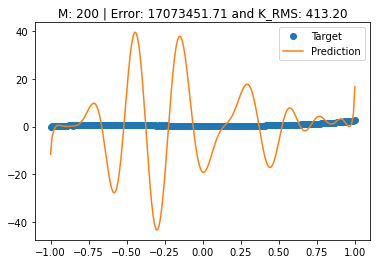

Coefficients: [-1.91869017e+01 -3.77333153e+01  4.03236500e+03 -1.51253198e+04
 -1.41913028e+05  7.28307885e+05  2.05927316e+06 -1.21599103e+07
 -1.61334188e+07  1.05158921e+08  7.76301778e+07 -5.52031064e+08
 -2.44850022e+08  1.90865702e+09  5.14374481e+08 -4.54781694e+09
 -6.73170318e+08  7.64847865e+09  3.26848511e+08 -9.15436154e+09
  6.90184496e+08  7.72551524e+09 -1.87726040e+09 -4.38104161e+09
  2.34244913e+09  1.36901801e+09 -1.74706944e+09 -1.10384759e+07
  7.18718678e+08  6.96744331e+07 -9.27937959e+07 -4.64035011e+08
  5.97229859e+07  4.63022726e+08 -2.56238599e+08 -2.51267477e+08
  3.37751562e+08  2.03914305e+08 -2.51082527e+08 -2.62791840e+08
  1.30861719e+08  1.96278802e+08 -8.11513399e+07  2.91062515e+07
  7.85344523e+07 -1.91302836e+08 -5.42815539e+07  1.57053827e+08
  1.33455839e+07 -6.83390091e+07 -7.12311298e+06  3.46040601e+07
  1.84783987e+07 -2.69428210e+07 -1.18084276e+07  1.37995145e+07
  8.99060105e+06  9.88587420e+06 -1.32069881e+07 -1.48624852e+07
  1.0363830

In [273]:
input = load_data("sampleData/X")
X, t = input
X = np.array(X)
t = np.array(t)

M =200
k = 5
gamma = 0.0
fit = solve_curve_fitting_k(X, t, M,k,gamma)
w = fit[0]
y = fit[1]
error = fit[2]
rms = fit[3]
avg_error = fit[4]
k_rms = fit[5]
errorlist = fit[6]
error_TRAINlist = fit[8]
plt.plot(X, t, 'o', label='Target')
plt.plot(X, y, '-', label='Prediction')
plt.legend()
plt.title('M: {:.0f}'.format(M)+' | Error: {:.2f}'.format(avg_error) + ' and K_RMS: {:.2f}'.format(k_rms))
plt.show()

    
print('Coefficients:', w)
# print('Predicted values:', y)
print('Mean Squared Error:', avg_error)
print('Root-Mean-Squared:', k_rms)

Test-Average Error = [0.8650912263619658, 0.8590985733399791, 0.8542488061657374, 0.8509979703735454, 0.8462340506426436]
Train-Average Error = [0.8142189544661651, 0.839215342249309, 0.858789691474825, 0.8716040633258888, 0.889963792329525]
Test-Average Error = [0.5096585895921026, 0.5068963888926057, 0.5017978832964006, 0.49897870638391706, 0.49335082294223864]
Train-Average Error = [0.4735742494644549, 0.480686064465134, 0.5016267793206914, 0.5133409512549539, 0.5355575321445485]
Test-Average Error = [0.41343961253296513, 0.4116432846395291, 0.40745383041763955, 0.4033835841798188, 0.39994685402994146]
Train-Average Error = [0.38317838160329404, 0.3870959042560054, 0.4041718772140351, 0.42027326877196225, 0.4352184385749769]
Test-Average Error = [0.26206253577751987, 0.26153289623053605, 0.2616022883239342, 0.2631527297097172, 0.2666349551063365]
Train-Average Error = [0.27199516152992104, 0.2585689303076242, 0.2527713091834455, 0.25306867551159823, 0.251096531290386]
Test-Average E

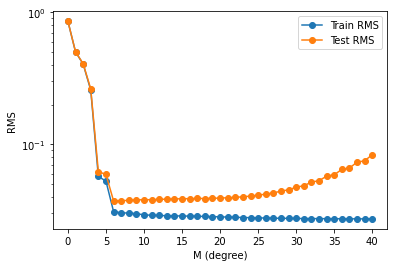

In [268]:
train_rms, test_rms = plot_tt_k(X, t, M,k,gamma)


In [ ]:
# print('Best:', find_best_polynomial_order(X, t, M, k, gamma))


In [274]:
def when_diverges(train, test):
    for i in range(5, len(train)):
        if train[i] > train[i-1] and train[i] > test[i]:
            return i
        if test[i] > test[i-1] and test[i] > train[i]:
            return i
        # if train[i] > train[i-1] != (test[i] > test[i-1]):
        #     return i
    return None


In [275]:
index = when_diverges(train_rms, test_rms)
index - 1

6